* I followed this tutorial: https://code.visualstudio.com/docs/datascience/data-science-tutorial
* `conda create -n myenv python=3.10 pandas jupyter seaborn scikit-learn keras tensorflow`
* `conda activate myenv`
* Ctrl + Shift + P: Select Interpreter. Click Refresh icon of the command bar. Select myenv: [StackOverflow](https://stackoverflow.com/questions/68717327/conda-environment-not-showing-up-in-vs-code)
* Data I used is titanic3.csv
* This notebook contains data read with pandas
* * Data type conversions
* * Multiple plottings
* * Converting male-female to numerical values
* * Calculates survival correlation with different variables

In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('titanic3.csv')

Change `?` symbol with numpy's `NaN`
Change data type of age and fare to float64

In [5]:
data.replace('?', np.nan, inplace= True)
data = data.astype({"age": np.float64, "fare": np.float64})

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='survived', ylabel='fare'>

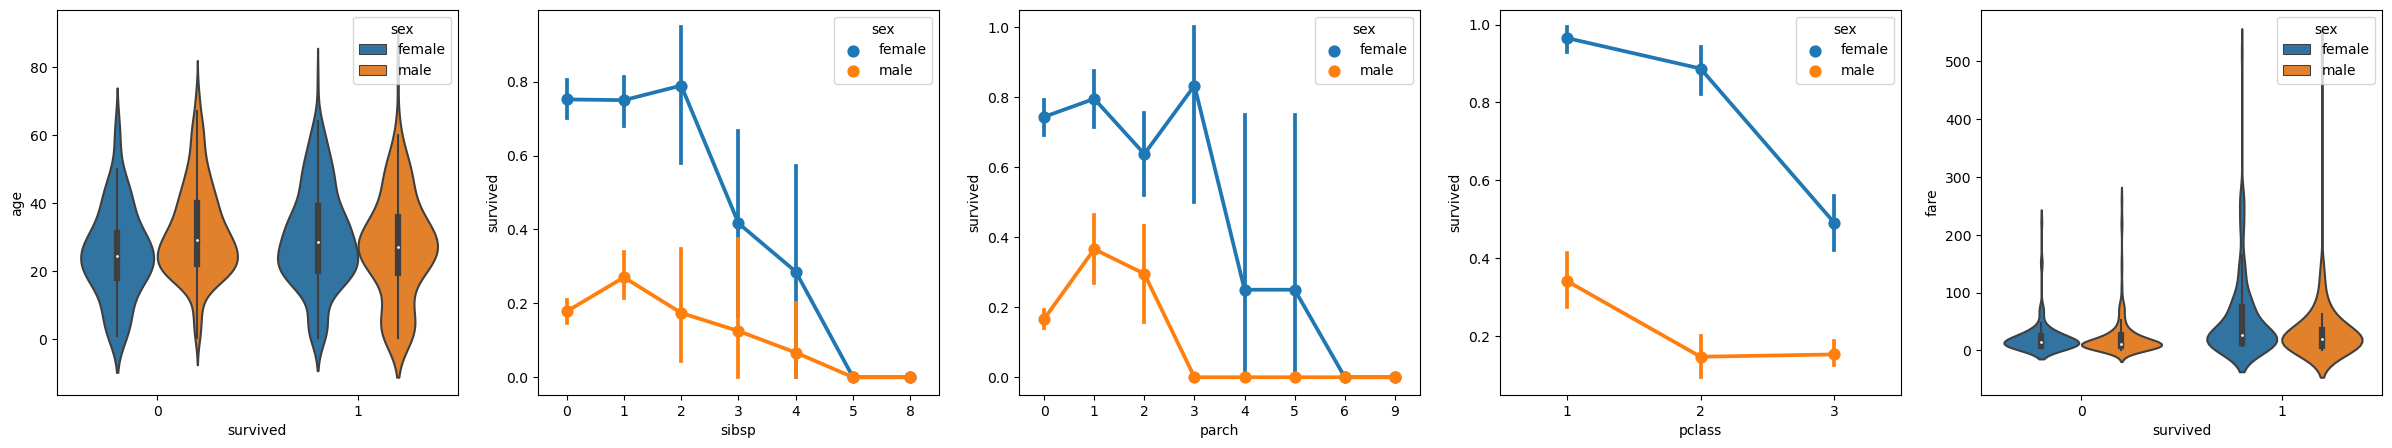

In [7]:
fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

These graphs are helpful in seeing some of the relationships between survival and the input variables of the data, but it's also possible to use pandas to calculate correlations. To do so, all the variables used need to be numeric for the correlation calculation and currently gender is stored as a string. To convert those string values to integers, add and run the following code.

In [8]:
data.replace({'male': 1, 'female': 0}, inplace=True)

/tmp/ipykernel_111092/2851430834.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'male': 1, 'female': 0}, inplace=True)


Now, you can analyze the correlation between all the input variables to identify the features that would be the best inputs to a machine learning model. The closer a value is to 1, the higher the correlation between the value and the result. Use the following code to correlate the relationship between all variables and survival.

In [11]:
data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN


In [12]:
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN
relatives,0.201719


In [13]:
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()

# Train and evaluate a model

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)

Next, you'll normalize the inputs such that all features are treated equally. For example, within the dataset the values for age range from ~0-100, while gender is only a 1 or 0. By normalizing all the variables, you can ensure that the ranges of values are all the same. Use the following code in a new code cell to scale the input values.

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

There are many different machine learning algorithms that you could choose from to model the data. The scikit-learn library also provides support for many of them and a chart to help select the one that's right for your scenario. For now, use the Naïve Bayes algorithm, a common algorithm for classification problems. Add a cell with the following code to create and train the algorithm.

In [16]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

With a trained model, you can now try it against the test data set that was held back from training. Add and run the following code to predict the outcome of the test data and calculate the accuracy of the model.

In [17]:
from sklearn import metrics
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885


# (Optional) Use a neural network

The first step is to import the required libraries and to create the model. In this case, you'll use a Sequential neural network, which is a layered neural network wherein there are multiple layers that feed into each other in sequence.

In [18]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

2024-04-12 21:17:39.960012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 21:17:42.482149: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


After defining the model, the next step is to add the layers of the neural network. For now, let's keep things simple and just use three layers. Add the following code to create the layers of the neural network.

In [19]:
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5))
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

* The first layer will be set to have a dimension of 5, since you have five inputs: sex, pclass, age, relatives, and fare.
* The last layer must output 1, since you want a 1-dimensional output indicating whether a passenger would survive.
* The middle layer was kept at 5 for simplicity, although that value could have been different.  

The rectified linear unit (relu) activation function is used as a good general activation function for the first two layers, while the sigmoid activation function is required for the final layer as the output you want (of whether a passenger survives or not) needs to be scaled in the range of 0-1 (the probability of a passenger surviving).

You can also look at the summary of the model you built with this line of code:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


Once the model is created, it needs to be compiled. As part of this, you need to define what type of optimizer will be used, how loss will be calculated, and what metric should be optimized for. Add the following code to build and train the model. You'll notice that after training, the accuracy is ~61%.
> Note: This step may take anywhere from a few seconds to a few minutes to run depending on your machine.

In [21]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
27/27 [==============================] - 1s 3ms/step - loss: 0.6921 - accuracy: 0.5694
Epoch 2/50
27/27 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5861
Epoch 3/50
27/27 [==============================] - 0s 1ms/step - loss: 0.6852 - accuracy: 0.6256
Epoch 4/50
27/27 [==============================] - 0s 2ms/step - loss: 0.6761 - accuracy: 0.7368
Epoch 5/50
27/27 [==============================] - 0s 2ms/step - loss: 0.6600 - accuracy: 0.7763
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.7691
Epoch 7/50
27/27 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.7679
Epoch 8/50
27/27 [==============================] - 0s 3ms/step - loss: 0.5880 - accuracy: 0.7667
Epoch 9/50
27/27 [==============================] - 0s 3ms/step - loss: 0.5686 - accuracy: 0.7691
Epoch 10/50
27/27 [==============================] - 0s 3ms/step - loss: 0.5514 - accuracy: 0.7691
Epoch 11/50
27/27 [

Now that the model is built and trained, we can see how it works against the test data.

In [22]:
y_pred = np.rint(model.predict(X_test).flatten())
print(metrics.accuracy_score(y_test, y_pred))

7/7 [==============================] - 0s 3ms/step
0.7990430622009569
